In [1]:
%matplotlib inline
# Built-in IPython extension to reload modules when updated.
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.auto import tqdm
import copy

# Custom modules
from S4 import *

In [3]:
# Load dataset
# Use the smaller test set to train faster
MNIST_TEST = datasets.MNIST(root='./../datasets', train=False, download=True, transform=transforms.ToTensor())

dataloader = DataLoader(MNIST_TEST, shuffle=True, batch_size=256)
testloader = DataLoader(MNIST_TEST, shuffle=False, batch_size=1)

In [4]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
device

device(type='cpu')

# MNIST Classification

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/10 loss: 2.30


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/10 loss: 2.23


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/10 loss: 2.09


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/10 loss: 1.99


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/10 loss: 1.94


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6/10 loss: 1.90


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7/10 loss: 1.87


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8/10 loss: 1.86


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9/10 loss: 1.83


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10/10 loss: 1.82


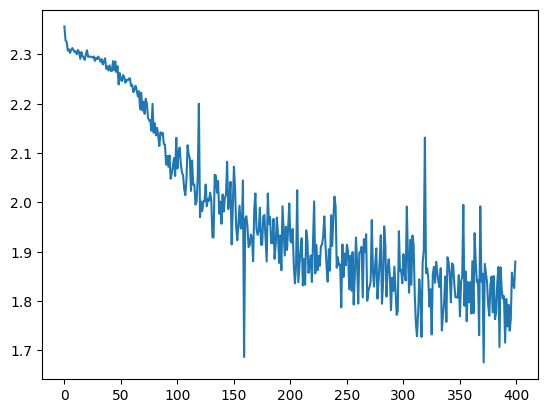

In [5]:
torch.manual_seed(42)

MLP = nn.Sequential(
    Lambda(lambda x: x.reshape(-1, 784)),
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
)
model = nn.Sequential(
    nn.Linear(1, 32),
    S4Block(32, 64),
    Lambda(lambda x: x.mean(dim=1)),
    nn.Linear(32, 10),
)
# Replace the model with simple MLP to see if it can learn
#model = MLP
model.to(device)

num_epochs = 10

model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
losses = []
for epoch in tqdm(range(num_epochs), position=0, leave=True):
    train_loss = 0.0
    for batch in tqdm(dataloader, leave=False): 
        img, y = batch
        # Convert image to a signal with L = 784 and dimension 1
        img = img.to(device).reshape(-1, 784, 1)
        y_hat = model(img)
        loss = criterion(y_hat, y)

        loss_val = loss.detach().cpu().item()
        train_loss += loss_val / len(dataloader)
        losses.append(loss_val)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs} loss: {train_loss:.2f}")

plt.plot(losses)
plt.show()

In [6]:
total, correct = 0, 0
for x, y in dataloader:
    x, y = x.to(device).reshape(-1, 784, 1), y.to(device)
    y_hat = model(x)
    y_hat = torch.argmax(y_hat, dim=-1)
    total += y.shape[0]
    correct += (y_hat == y).sum().item()
accuracy = correct / total
accuracy

0.3507

# MNIST Generation

Predict the next pixel based on the given sequence of pixels.

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/2 loss: 0.11


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/2 loss: 0.04


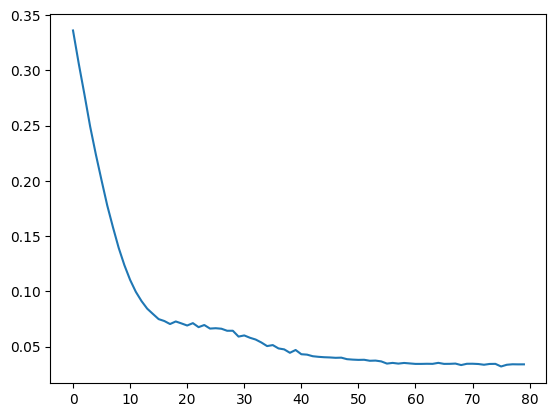

In [7]:
torch.manual_seed(42)

model = SequentialS4(
    nn.Linear(1, 32),
    S4Block(32, 64),
    nn.Linear(32, 1),
    nn.Sigmoid(),
)
model.to(device)

num_epochs = 2

model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()
#criterion = torch.nn.CrossEntropyLoss()
losses = []
for epoch in tqdm(range(num_epochs), position=0, leave=True):
    train_loss = 0.0
    for batch in tqdm(dataloader, leave=False): 
        img, _ = batch
        # Convert image to a signal with L = 784 and dimension 1
        img = img.to(device).reshape(-1, 784, 1)
        x = img[:, :-1, :]  # First L-1 elements
        y = img[:, 1:, :]   # Last L-1 elements
        # For each sample i, predict the next sample (i+1) from the slice between 0 to i
        y_hat = model(x)
        loss = criterion(y_hat, y)

        loss_val = loss.detach().cpu().item()
        train_loss += loss_val / len(dataloader)
        losses.append(loss_val)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs} loss: {train_loss:.2f}")

plt.plot(losses)
plt.show()

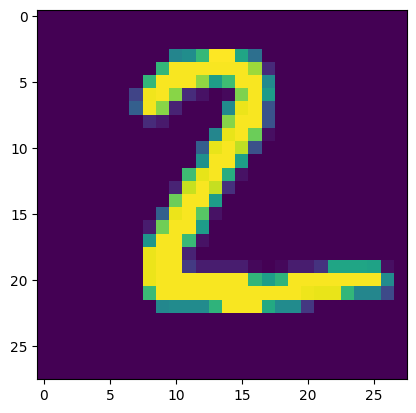

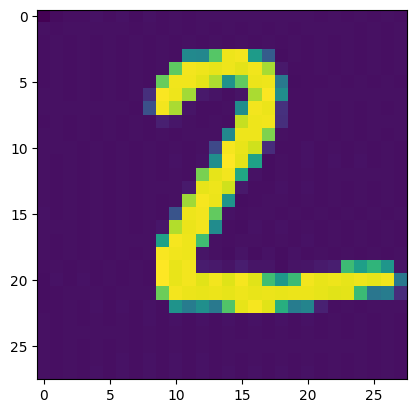

In [8]:
model.eval()

with torch.no_grad():
    img, _ = MNIST_TEST[1]
    img = img.to(device).reshape(-1, 784, 1)
    x = img[:, :-1, :]  # First L-1 elements
    y = img[:, 1:, :]   # Last L-1 elements
    y_hat = model(x)
    newimg = torch.cat([img[:,0:1,:], y_hat], dim=1)
    plt.figure()
    plt.imshow(img.reshape(28, 28, 1))
    plt.figure()
    plt.imshow(newimg.reshape(28, 28, 1))

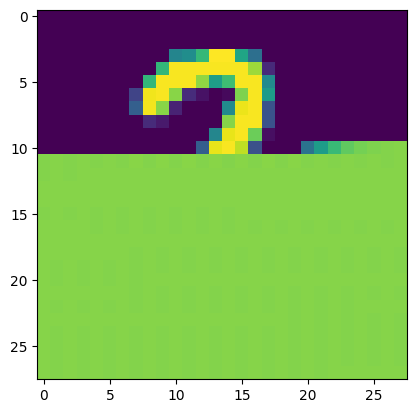

In [9]:
model.eval()

with torch.no_grad():
    img, _ = MNIST_TEST[1]
    img = img.to(device).reshape(-1, 784, 1)
    x = img[0, :300, :]
    sample = model.autoregressive_sample(484, x)
    plt.figure()
    plt.imshow(sample.reshape(28, 28, 1))